In [1]:
!pip install transformers datasets peft accelerate bitsandbytes gradio -q

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model, TaskType
import torch

model_id = "Qwen/Qwen3-0.6B"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["c_proj", "q_proj", "v_proj", "k_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)

#Veri Hazırlama
import pandas as pd
from datasets import Dataset

from google.colab import files
uploaded = files.upload()

df = pd.read_excel("TrkceTwit.xlsx")
df = df[df["Duygu"].isin([0, 1, 2])].copy()
df = df.rename(columns={"Tweets": "text", "Duygu": "label"})
df = df[["text", "label"]]

dataset = Dataset.from_pandas(df)

def format_sample(example):
    label_map = {0: "Olumsuz", 1: "Olumlu", 2: "Tarafsız"}
    prompt = f"Metin: {example['text']}\nDuygu: "
    answer = " " + label_map[example["label"]]
    return {"text": prompt + answer}

text_dataset = dataset.map(format_sample)

def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_attention_mask=False
    )

tokenized_dataset = text_dataset.map(tokenize_function, remove_columns=["text"])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/9.73k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Saving TrkceTwit.xlsx to TrkceTwit.xlsx


Map:   0%|          | 0/4202 [00:00<?, ? examples/s]

Map:   0%|          | 0/4202 [00:00<?, ? examples/s]

In [2]:
#Eğitim
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

training_args = TrainingArguments(
    output_dir="./qwen3-finetuned",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=5,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=10,
    save_strategy="epoch",
    remove_unused_columns=False,
    report_to="none"
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

trainer.train()

#Doğruluk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

def classify_with_generate(df, model, tokenizer, batch_size=8):
    preds, labels = [], []
    model.eval()

    for i in tqdm(range(0, len(df), batch_size)):
        batch = df.iloc[i:i+batch_size]
        prompts = [
            f"Soru: Bu cümle olumlu mu, olumsuz mu, yoksa tarafsız mı?\nMetin: {text}\nCevap:"
            for text in batch["text"]
        ]
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=15)
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        for output in decoded:
            last_line = output.strip().split("\n")[-1].lower()
            if "olumsuz" in last_line:
                preds.append(0)
            elif "olumlu" in last_line:
                preds.append(1)
            elif "tarafsız" in last_line:
                preds.append(2)
            else:
                preds.append(-1)

        labels.extend(batch["label"].tolist())

    return preds, labels

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,4.500800
20,3.917000
30,3.614100
40,3.494000
50,3.563400
60,3.354400
70,3.326300
80,3.342900
90,3.450100
100,3.264200


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

100%|██████████| 526/526 [15:46<00:00,  1.80s/it]


✅ Doğruluk: 0.33
🎯 F1 Skoru: 0.31


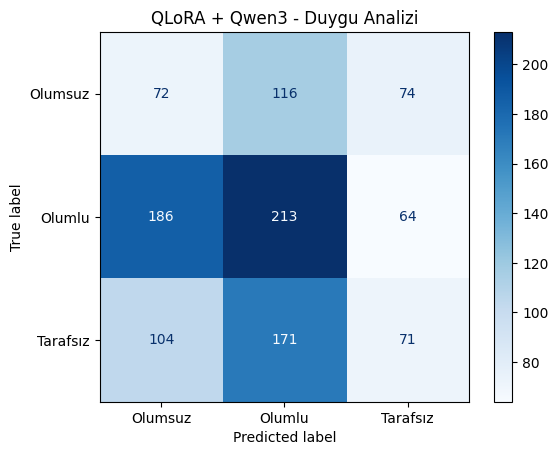

In [3]:
preds, labels = classify_with_generate(df, model, tokenizer)
final_preds, final_labels = zip(*[(p, l) for p, l in zip(preds, labels) if p != -1])

acc = accuracy_score(final_labels, final_preds)
f1 = f1_score(final_labels, final_preds, average="macro")
cm = confusion_matrix(final_labels, final_preds)

print(f"Doğruluk: {acc:.2f}")
print(f"F1 Skoru: {f1:.2f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Olumsuz", "Olumlu", "Tarafsız"])
disp.plot(cmap="Blues")
plt.title("QLoRA + Qwen3 - Duygu Analizi")
plt.grid(False)
plt.show()

In [4]:
#Arayüz
import gradio as gr

def predict_sentiment(text):
    prompt = f"Soru: Bu cümle olumlu mu, olumsuz mu, yoksa tarafsız mı?\nMetin: {text}\nCevap:"
    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False).to(model.device)
    output = model.generate(**inputs, max_new_tokens=15)
    decoded = tokenizer.decode(output[0], skip_special_tokens=True).lower()

    if "olumsuz" in decoded:
        return "Olumsuz"
    elif "olumlu" in decoded:
        return "Olumlu"
    elif "tarafsız" in decoded:
        return "Tarafsız"
    else:
        return "Anlaşılamadı"

gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=4, placeholder="Bir Türkçe tweet girin..."),
    outputs="text",
    title="Qwen3 Türkçe Duygu Analizi",
    description="Eğitilmiş QLoRA + Qwen3 modeliyle duygu tahmini yapın."
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ac62d2669d6f96bf24.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
